# additional explanation by mladen:
Some preface : in the attached article the author does a well job explaining what he felt a 2 most important points of Trend Quality indicators calculation. What is not explained there is how the "direction" (or "reversal" as the coders of tradestation, metastock, amibroker ... call it) is determined. It is a difference of 2 emas (7 and 15 ema by default) and since the difference of 2 emas is by definition macd, it turns out that the additional "spice" in these indicators is macd. It does not make these indicators a "yet another macd" indicator, since they are not that, but I felt it necessary to clarify that point too (to avoid some mis-expectations)

In [ ]:
import pandas as pd

df = pd.read_csv('./data/av_eurusd_daily.csv')
df.set_index("timestamp", inplace=True)

In [ ]:
df = df.head(365)

In [ ]:
df

In [ ]:
# calculating tq using the "pandas_ta" way

from pandas import concat, DataFrame, Series
import numpy as np
from pandas_ta import Imports
from pandas_ta.momentum import macd
from pandas_ta.utils import get_offset, verify_series, signals

def tq(close, trend_period=None, noise_period=None, correction_factor=None, fast_length=None, slow_length=None, talib=None, **kwargs):
  """Indicator: Trend Quality Q Indicator (TQ)"""
  # validate arguments
  trend_period = int(trend_period) if trend_period and trend_period > 0 else 4
  noise_period = int(noise_period) if noise_period and noise_period > 0 else 250
  correction_factor = int(correction_factor) if correction_factor and correction_factor > 0 else 2
  fast_length = int(fast_length) if fast_length and fast_length > 0 else 7
  slow_length = int(slow_length) if slow_length and slow_length > 0 else 14 
  close = verify_series(close, max(trend_period, noise_period, correction_factor, fast_length, slow_length))

  mode_tal = bool(talib) if isinstance(talib, bool) else True

  if close is None: return

  as_mode = kwargs.setdefault("asmode", False)

  # Calculcate Result

  # for now, not writing talib mode checks
  # if Imports["talib"] and mode_tal:

  # init df with close as passed close series of prices
  df = DataFrame(close, columns=['close'])
  # calculcate macd using pandas_ta
  calc_macd = macd(df['close'], fast=fast_length, slow=slow_length, talib=False)
  # extract the first column of the macd calculation
  df['macd'] = calc_macd.iloc[:,0]
  # calculate the sign of the macd (1 if positive, -1 if negative, 0 if 0)
  df['sign'] = np.sign(df['macd'])
  # initialize cpc, trend, and tq columns
  df['cpc'] = 0
  df['trend'] = 0
  df['noise'] = 0
  df['tq'] = 0
  # resetting index here to access indexes as ints instead of datetime
  datetime = df.index
  df.reset_index(inplace=True)
  
  # iterate over df to calculate tq using traditional for loop approach. Not preferred.
  for row in df.itertuples():
    i = row.Index
    close = row.close
    macd_value = row.macd
    sign = row.sign
    cpc = row.cpc
    trend = row.trend
    tq = row.tq

    if i == 0:
      prev_close = close
      close = 0
      prev_sign = sign
      continue
    
    prev_close = df.at[i-1, 'close'] 
    change = abs(close - prev_close) 
    
    # in mladen's code, cpc and trend are reset to zero when
    # the macd sign changes.  Since cpc and trend are already
    # initialized to zero, the logic is now "do nothing unless
    # the signs are the same."
    if sign == prev_sign:
      cpc = sign * change + df.at[i-1, 'cpc']
      # trend is cpc smoothed
      trend = (cpc * (1/trend_period)) + (df.at[i-1, 'trend'] * (1 - (1/trend_period)))
      df.at[i, 'trend'] = trend

    # In the next few lines, mladen calculates dt, avg_dt, 
    # and noise.  I'm not sure what that does so I'll stop here.
      
    # add something to tq
    # end of loop
  
  df.set_index(datetime, inplace=True)
  tq = df['trend']

  _asmode = "AS" if as_mode else ""
  # chose not to include noise length and correction factor in props
  _props = f"_{fast_length}_{slow_length}"
  tq.name = f"TQ{_asmode}{_props}"
  tq.category = "trend"

  data = {tq.name: tq}
  df = DataFrame(data)
  df.name = f"TQ{_asmode}{_props}"
  df.category = tq.category

  # for now, not implementing signal indicators
  
  return df

In [ ]:
# return tq df without eurusd prices dataframe
tq(df['close'])

In [ ]:
# return eurusd prices with tq calculation
df['tq'] = tq(df['close'])
df


In [2]:
import pandas as pd
from pandas_ta.momentum import macd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# experiment with chunking operations in seperate cells

fast_length = 7
slow_length = 14
trend_period = 4
noise_period = 250
correction_factor = 2


df = pd.read_csv('./data/av_eurusd_daily.csv')
df.set_index("timestamp", inplace=True)
df = df.head(365)
calc_macd = macd(df['close'], fast=fast_length, slow=slow_length, talib=False)
df['macd'] = calc_macd.iloc[:,0]
df['sign'] = np.sign(df['macd'])


In [4]:
pd.set_option('display.max_rows', None)

In [49]:
df

,open,high,low,close,macd,sign,cpc,trend,noise_1,noise_2,tq
timestamp,,,,,,,,,,,
2023-11-16,1.08518,1.08955,1.08299,1.08572,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
2023-11-15,1.08788,1.08861,1.08313,1.08468,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
2023-11-14,1.06975,1.08875,1.06927,1.08787,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
2023-11-13,1.06826,1.07061,1.06647,1.06987,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
2023-11-10,1.06671,1.06930,1.06559,1.06848,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
2023-11-09,1.07076,1.07254,1.06598,1.06671,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
2023-11-08,1.06993,1.07160,1.06590,1.07090,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
2023-11-07,1.07168,1.07221,1.06640,1.06998,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
2023-11-06,1.07243,1.07563,1.07158,1.07173,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000


In [6]:
# chunking df by sign and returning as dict
df['sign'].fillna(0, inplace=True)
df["sign"].groupby((df["sign"] != df["sign"].shift()).cumsum()).groups

{1: ['2023-11-16', '2023-11-15', '2023-11-14', '2023-11-13', '2023-11-10', '2023-11-09', '2023-11-08', '2023-11-07', '2023-11-06', '2023-11-03', '2023-11-02', '2023-11-01', '2023-10-31'], 2: ['2023-10-30', '2023-10-27', '2023-10-26', '2023-10-25', '2023-10-24', '2023-10-23', '2023-10-20', '2023-10-19', '2023-10-18', '2023-10-17', '2023-10-16', '2023-10-13', '2023-10-12', '2023-10-11', '2023-10-10', '2023-10-09', '2023-10-06', '2023-10-05', '2023-10-04', '2023-10-03', '2023-10-02', '2023-09-29', '2023-09-28', '2023-09-27', '2023-09-26', '2023-09-25'], 3: ['2023-09-22', '2023-09-21', '2023-09-20', '2023-09-19', '2023-09-18', '2023-09-15', '2023-09-14', '2023-09-13', '2023-09-12', '2023-09-11', '2023-09-08', '2023-09-07', '2023-09-06', '2023-09-05', '2023-09-04', '2023-09-01', '2023-08-31', '2023-08-30', '2023-08-29', '2023-08-28', '2023-08-25', '2023-08-24', '2023-08-23', '2023-08-22', '2023-08-21', '2023-08-18', '2023-08-17', '2023-08-16', '2023-08-15', '2023-08-14', '2023-08-11', '2023

In [39]:
# chunking df by sign and returning as list of dfs
dfs = list(
    zip(
        *df.groupby(
          (df["sign"] != df["sign"].shift())
          .cumsum()
          )
    )
)[-1]

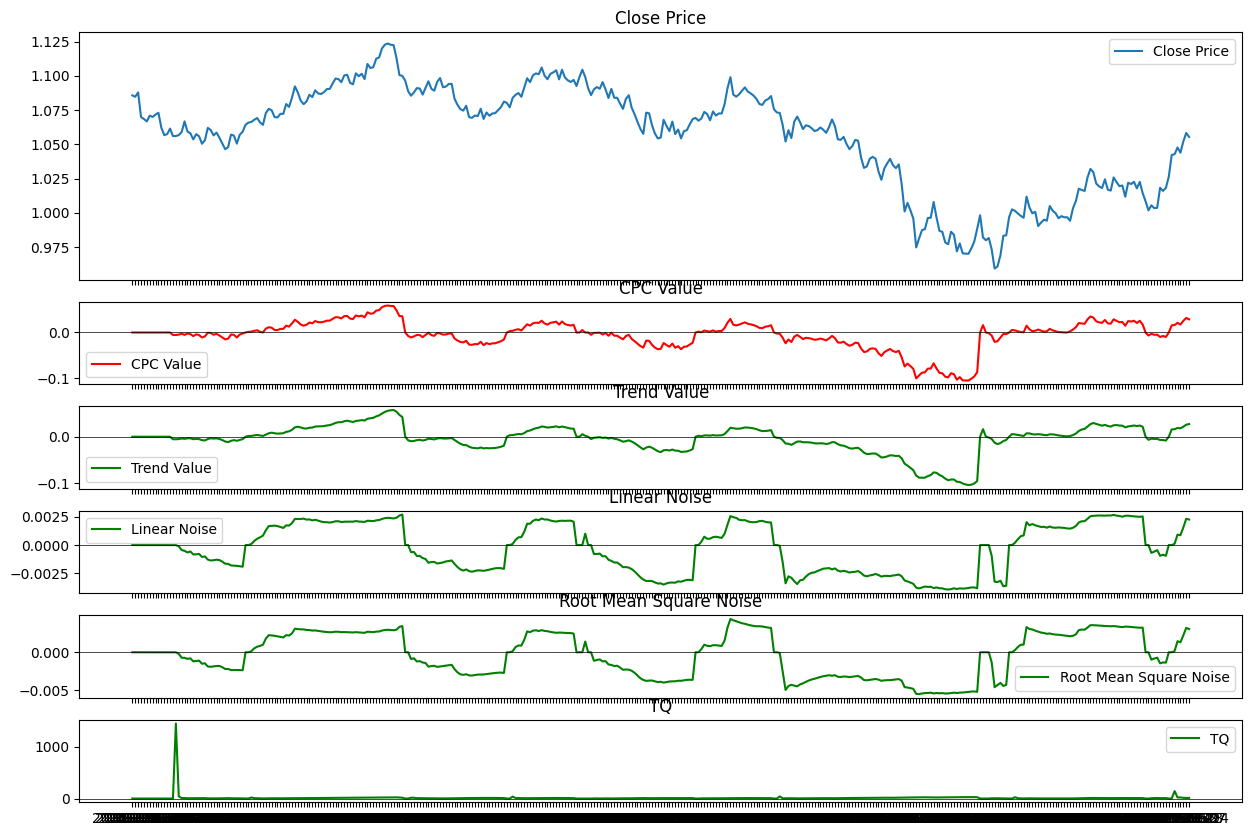

In [50]:
# attempt to calculate tq via chunking method
# this solution doesn't work because the df['tq'] column has a few abormally large values

fast_length = 7
slow_length = 14
trend_period = 4
noise_period = 250
correction_factor = 2


df = pd.read_csv('./data/av_eurusd_daily.csv')
df.set_index("timestamp", inplace=True)
df = df.head(365)
calc_macd = macd(df['close'], fast=fast_length, slow=slow_length, talib=False)
df['macd'] = calc_macd.iloc[:,0]
df['sign'] = np.sign(df['macd'])

df.fillna(0, inplace=True)

dfs = list(
    zip(
        *df.groupby(
          (df["sign"] != df["sign"].shift())
          .cumsum()
          )
    )
)[-1]

def tq_calc(df):
  df['cpc'] = abs(df['close'].diff().cumsum()) * df['sign']
  df['trend'] = df['cpc'].ewm(span=trend_period).mean()

  # linear noise approach
  df['noise_1'] = ((df['cpc'] - df['trend']).abs()).ewm(span=noise_period).mean() * df['sign']
  # root mean square noise approach
  df['noise_2'] = (((df['cpc'] - df['trend']) ** 2).ewm(span=noise_period).mean() ** 0.5) * df['sign']
  # calculate tq using either noise approach
  df['tq'] = df.apply(lambda row: row['trend'] / row['noise_1'] if row['noise_1'] != 0 else 0, axis=1)

# apply tq_calc to each chunk
for i in range(len(dfs)):
  tq_calc(dfs[i])

# concat chunks back into one df
  
df = pd.concat(dfs)

df.fillna(0, inplace=True)

fig, ax = plt.subplots(6, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1, 1, 1]}, figsize=(15, 10))

# Plot 1: Close price
ax[0].plot(df.index, df['close'], label='Close Price')
ax[0].set_title('Close Price')
ax[0].legend()

# Subplot 2: CPC value
ax[1].plot(df.index, df['cpc'], label='CPC Value', color='r')
ax[1].axhline(0, color='black', linewidth=0.5)  # Add zero line
ax[1].set_title('CPC Value')
ax[1].legend()

# Subplot 3: Trend value
ax[2].plot(df.index, df['trend'], label='Trend Value', color='g')
ax[2].axhline(0, color='black', linewidth=0.5)  # Add zero line
ax[2].set_title('Trend Value')
ax[2].legend()

# Subplot 4: Linear Noise
ax[3].plot(df.index, df['noise_1'], label='Linear Noise', color='g')
ax[3].axhline(0, color='black', linewidth=0.5)  # Add zero line
ax[3].set_title('Linear Noise')
ax[3].legend()

# Subplot 5: Root Mean Square Noise
ax[4].plot(df.index, df['noise_2'], label='Root Mean Square Noise', color='g')
ax[4].axhline(0, color='black', linewidth=0.5)  # Add zero line
ax[4].set_title('Root Mean Square Noise')
ax[4].legend()

# Subplot 6: TQ with Linear Noise
ax[5].plot(df.index, df['tq'], label='TQ', color='g')
ax[5].axhline(0, color='black', linewidth=0.5)  # Add zero line
ax[5].set_title('TQ')
ax[5].legend()

plt.show()


In [40]:
# tq calc function

def tq_calc(df):
  df['cpc'] = abs(df['close'].diff().cumsum()) * df['sign']
  df['trend'] = df['cpc'].ewm(span=trend_period).mean()
  df['noise_1'] = ((df['cpc'] - df['trend']).abs()).ewm(span=noise_period).mean() * df['sign']
  df['noise_2'] = (((df['cpc'] - df['trend']) ** 2).ewm(span=noise_period).mean() ** 0.5) * df['sign']
  df['tq_1'] = (df['trend'] / df['noise_1']) * correction_factor
  df['tq_2'] = (df['trend'] / df['noise_2']) * correction_factor
  #df['tq'] = ((df['trend'] / df['noise']) * correction_factor)


In [42]:
# apply tq_calc to each chunk
for i in range(len(dfs)):
  tq_calc(dfs[i])

In [43]:
# concat chunks back into one df
df = pd.concat(dfs)
df

,open,high,low,close,macd,sign,cpc,trend,noise_1,noise_2,tq_1,tq_2
timestamp,,,,,,,,,,,,
2023-11-16,1.08518,1.08955,1.08299,1.08572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-15,1.08788,1.08861,1.08313,1.08468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-14,1.06975,1.08875,1.06927,1.08787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-13,1.06826,1.07061,1.06647,1.06987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-10,1.06671,1.06930,1.06559,1.06848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-09,1.07076,1.07254,1.06598,1.06671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-08,1.06993,1.07160,1.06590,1.07090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-07,1.07168,1.07221,1.06640,1.06998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-06,1.07243,1.07563,1.07158,1.07173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# fill nans
df.fillna(0, inplace=True)
df

,open,high,low,close,macd,sign,cpc,trend,noise_1,noise_2,tq_1,tq_2
timestamp,,,,,,,,,,,,
2023-11-16,1.08518,1.08955,1.08299,1.08572,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-11-15,1.08788,1.08861,1.08313,1.08468,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-11-14,1.06975,1.08875,1.06927,1.08787,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-11-13,1.06826,1.07061,1.06647,1.06987,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-11-10,1.06671,1.06930,1.06559,1.06848,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-11-09,1.07076,1.07254,1.06598,1.06671,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-11-08,1.06993,1.07160,1.06590,1.07090,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-11-07,1.07168,1.07221,1.06640,1.06998,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-11-06,1.07243,1.07563,1.07158,1.07173,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


In [46]:
# print all df chunks
for i in range(len(dfs)):
  print(dfs[i])

               open     high      low    close  macd  sign  cpc  trend  noise  \
timestamp                                                                       
2023-11-16  1.08518  1.08955  1.08299  1.08572   NaN   0.0  NaN    NaN    NaN   
2023-11-15  1.08788  1.08861  1.08313  1.08468   NaN   0.0  0.0    0.0    0.0   
2023-11-14  1.06975  1.08875  1.06927  1.08787   NaN   0.0  0.0    0.0    0.0   
2023-11-13  1.06826  1.07061  1.06647  1.06987   NaN   0.0  0.0    0.0    0.0   
2023-11-10  1.06671  1.06930  1.06559  1.06848   NaN   0.0  0.0    0.0    0.0   
2023-11-09  1.07076  1.07254  1.06598  1.06671   NaN   0.0  0.0    0.0    0.0   
2023-11-08  1.06993  1.07160  1.06590  1.07090   NaN   0.0  0.0    0.0    0.0   
2023-11-07  1.07168  1.07221  1.06640  1.06998   NaN   0.0  0.0    0.0    0.0   
2023-11-06  1.07243  1.07563  1.07158  1.07173   NaN   0.0  0.0    0.0    0.0   
2023-11-03  1.06203  1.07467  1.06144  1.07300   NaN   0.0  0.0    0.0    0.0   
2023-11-02  1.05670  1.06676

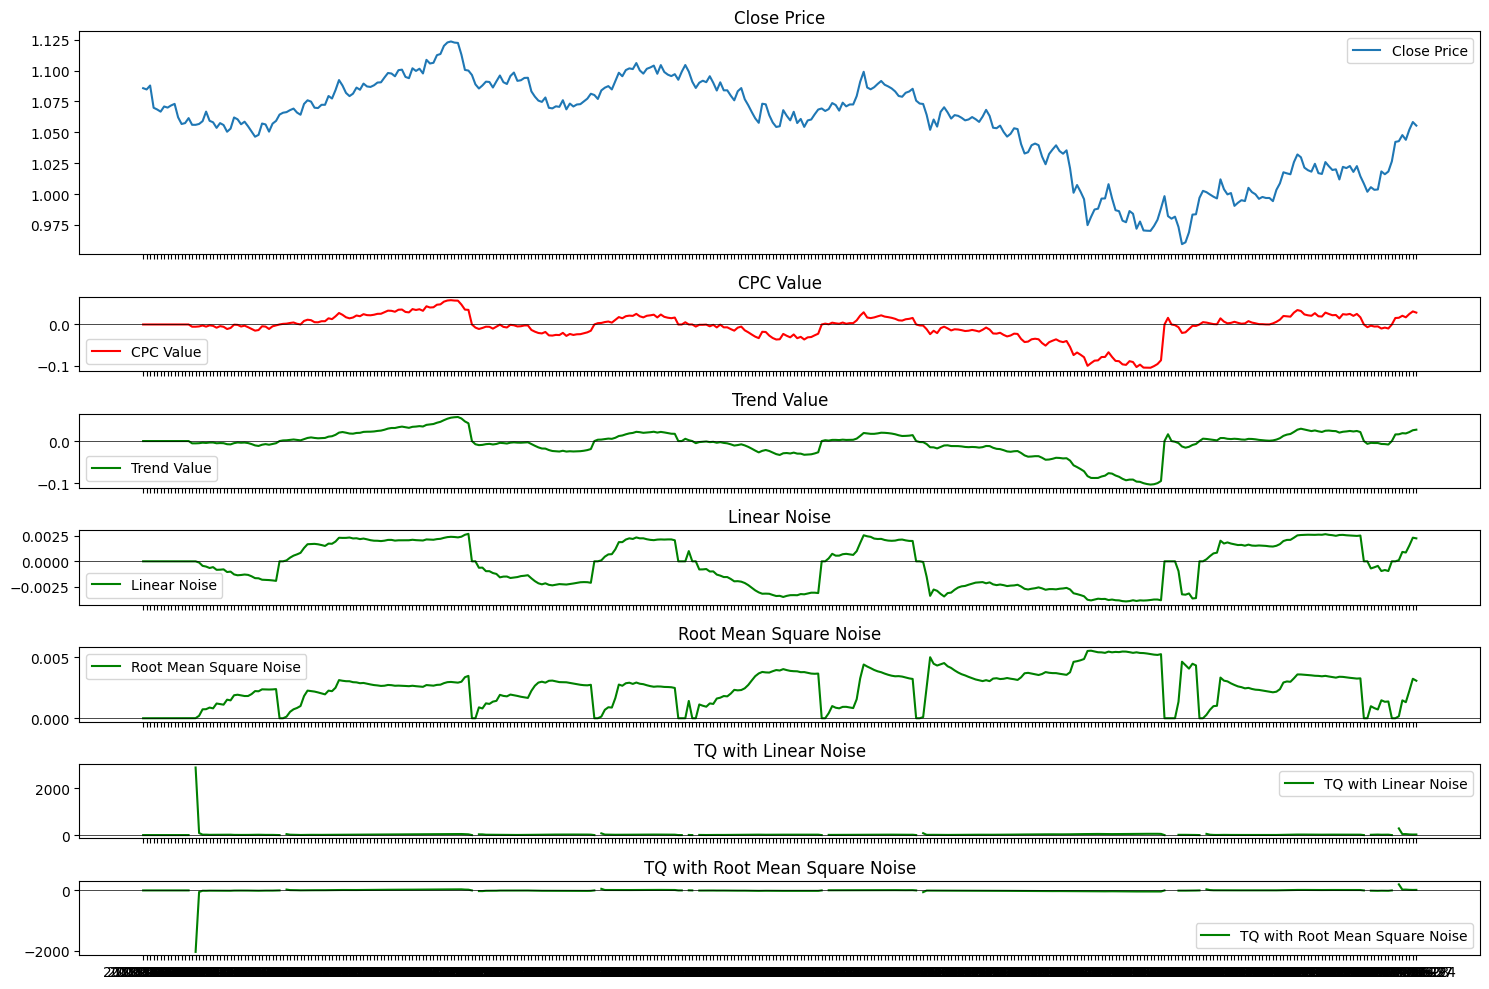

In [45]:
# plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(7, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1, 1, 1, 1]}, figsize=(15, 10))

# Plot 1: Close price
ax[0].plot(df.index, df['close'], label='Close Price')
ax[0].set_title('Close Price')
ax[0].legend()

# Subplot 2: CPC value
ax[1].plot(df.index, df['cpc'], label='CPC Value', color='r')
ax[1].axhline(0, color='black', linewidth=0.5)  # Add zero line
ax[1].set_title('CPC Value')
ax[1].legend()

# Subplot 3: Trend value
ax[2].plot(df.index, df['trend'], label='Trend Value', color='g')
ax[2].axhline(0, color='black', linewidth=0.5)  # Add zero line
ax[2].set_title('Trend Value')
ax[2].legend()

# Subplot 4: Linear Noise
ax[3].plot(df.index, df['noise_1'], label='Linear Noise', color='g')
ax[3].axhline(0, color='black', linewidth=0.5)  # Add zero line
ax[3].set_title('Linear Noise')
ax[3].legend()

# Subplot 5: Root Mean Square Noise
ax[4].plot(df.index, df['noise_2'], label='Root Mean Square Noise', color='g')
ax[4].axhline(0, color='black', linewidth=0.5)  # Add zero line
ax[4].set_title('Root Mean Square Noise')
ax[4].legend()

# Subplot 6: TQ with Linear Noise
ax[5].plot(df.index, df['tq_1'], label='TQ with Linear Noise', color='g')
ax[5].axhline(0, color='black', linewidth=0.5)  # Add zero line
ax[5].set_title('TQ with Linear Noise')
ax[5].legend()

# Subplot 7: TQ with Root Mean Square Noise
ax[6].plot(df.index, df['tq_2'], label='TQ with Root Mean Square Noise', color='g')
ax[6].axhline(0, color='black', linewidth=0.5)  # Add zero line
ax[6].set_title('TQ with Root Mean Square Noise')
ax[6].legend()

plt.tight_layout()
plt.show()


In [ ]:
# cpc approach using df.apply()
# this doesn't work that well since it returns a list inside each cell and prevents plotting
prev_macd_sign = None

def calculate_cpc(x):
    global prev_macd_sign
    if prev_macd_sign is not None and x['macd_sign'] != prev_macd_sign:
        cpc = 0
    else:
        cpc = x['close_diff'].cumsum()
    prev_macd_sign = x['macd_sign']
    return cpc

df['close_diff'] = df['close'].diff()
df['macd_sign'] = np.sign(df['macd'])

df['cpc'] = df.apply(calculate_cpc, axis=1)